# Predicting Client Subscription to Term Deposits - Binary Classification Task

### Імпорт бібліотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Завантаження даних

In [4]:
df = pd.read_csv("bank-additional-full.csv", sep=';')

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### EDA

In [5]:
# Поглянемо на розмірність нашого датасету
df.shape

(41188, 21)

Наш набір даних містить 41188 рядків спостережень і 21 колонку характеристик.

### Перевірка на дублікати

In [6]:
duplicates = df[df.duplicated()]
print(duplicates)

       age          job   marital            education  default housing loan  \
1266    39  blue-collar   married             basic.6y       no      no   no   
12261   36      retired   married              unknown       no      no   no   
14234   27   technician    single  professional.course       no      no   no   
16956   47   technician  divorced          high.school       no     yes   no   
18465   32   technician    single  professional.course       no     yes   no   
20216   55     services   married          high.school  unknown      no   no   
20534   41   technician   married  professional.course       no     yes   no   
25217   39       admin.   married    university.degree       no      no   no   
28477   24     services    single          high.school       no     yes   no   
32516   35       admin.   married    university.degree       no     yes   no   
36951   45       admin.   married    university.degree       no      no   no   
38281   71      retired    single    uni

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(41176, 21)

Ми перевірили дані на дублікати і виявили 12 рядків, які мають однакові значення в усіх стовпцях і їх можна вважати повністю повторюваними, очищаємо дані від повторів.

Після видалення дублікатів кількість рядків зменшилась до 41176.


### Загальна характеристика набору даних

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

Наш набір даних містить 10 числових колонок (5 типу int64 і 5 типу float64) та 11 категоріальних колонок (типу object).


In [10]:
# Визначення числових колонок для ознак
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Визначення категоріальних колонок для ознак
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Числові колонки:", numeric_cols)
print("Категоріальні колонки:", categorical_cols)

Числові колонки: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Категоріальні колонки: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


### Перевірка на наявність пропущених значень

In [11]:
print(df.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


У нас немає пропущених значень, проте рядки з 'unknown' технічно можуть вважатися прихованими "відсутніми значеннями", тому виведемо їх для подальшого аналізу.

In [12]:
import pandas as pd

# Створення таблиці з підрахунком 'unknown' та обчисленням у відсотках
unknown_summary = pd.DataFrame([
    {
        'column': col,
        'unknown_count': int(df[col].value_counts(dropna=False).get('unknown', 0)),
        'unknown_percent': round((df[col].value_counts(dropna=False).get('unknown', 0)) / len(df) * 100, 2)
    }
    for col in categorical_cols
    if 'unknown' in df[col].values
])

print(unknown_summary)

      column  unknown_count  unknown_percent
0        job            330             0.80
1    marital             80             0.19
2  education           1730             4.20
3    default           8596            20.88
4    housing            990             2.40
5       loan            990             2.40


Аналіз по кожній змінній:

default (20.88%): залишимо 'unknown' як окрему категорію.
Причина: заміна понад 20% значень на моду або інше — це ризик перекосити розподіл.

education (4.2%): залишимо 'unknown'

housing, loan (по 2.4%): залишимо 'unknown'

job, marital(0.8% і 0.19%): заповнимо модою

### Аналіз категоріальних колонок

In [13]:
# Кількість унікальних значень для категоріальних колонок
print(df[categorical_cols].nunique())

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
y               2
dtype: int64


In [14]:
# Розподіл значень у категоріальних колонках
for col in categorical_cols:
    print(f"Розподіл значень у колонці '{col}':")
    print(df[col].value_counts())
    print("\n" + "-"*20 + "\n")

Розподіл значень у колонці 'job':
job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

--------------------

Розподіл значень у колонці 'marital':
marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64

--------------------

Розподіл значень у колонці 'education':
education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64

--------------------

Розподіл значень у колонці 'default':
default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64

---------------

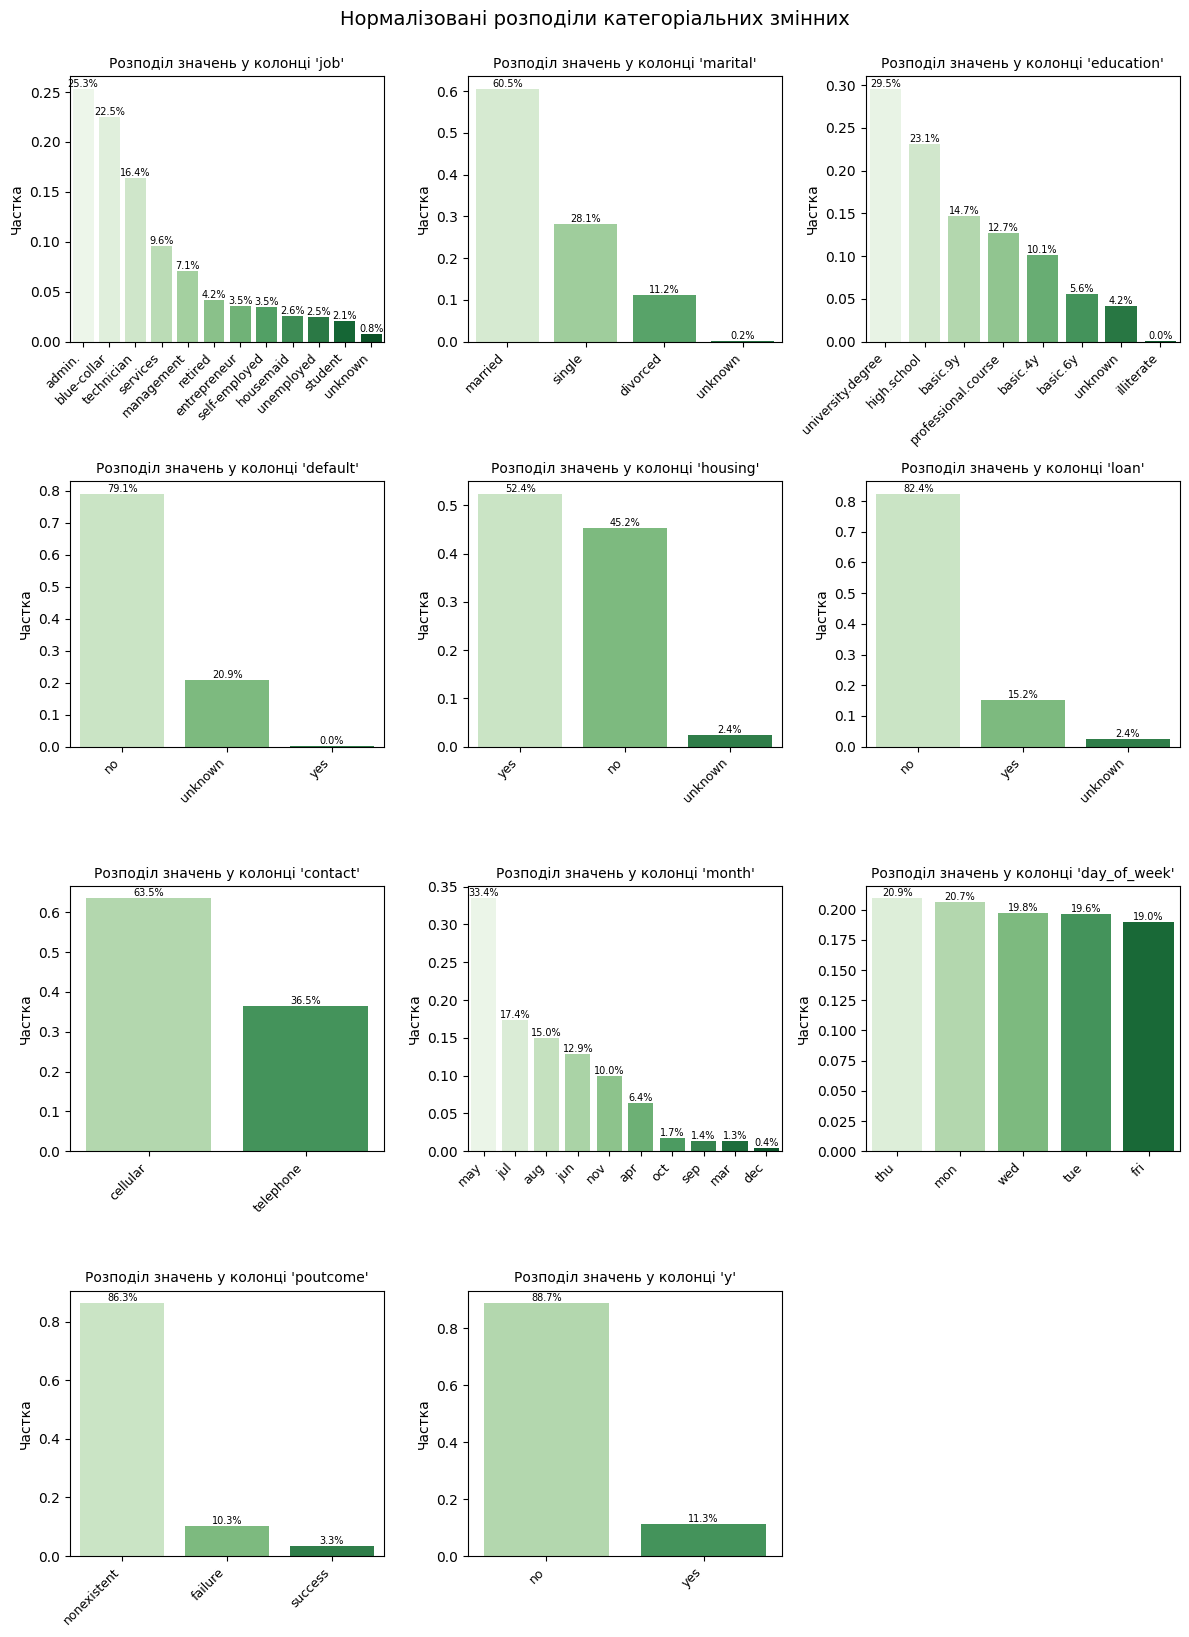

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Побудова графіків
plt.figure(figsize=(12, 16))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 3, i)

    data = df[col].value_counts(normalize=True).sort_index()
    order = df[col].value_counts().index

    ax = sns.countplot(data=df, x=col, palette='Greens',
                       order=order, stat="probability")

    plt.title(f"Розподіл значень у колонці '{col}'", fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.xlabel("")
    plt.ylabel("Частка")

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height*100:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.suptitle("Нормалізовані розподіли категоріальних змінних", fontsize=14, y=1.02)
plt.show()



Загальні спостереження по змінним:

Цільова змінна **y**:

88.7% — "no", лише 11.3% — "yes". Сильний дисбаланс класів, потребує уваги при моделюванні (наприклад, застосування class_weight, SMOTE, тощо).

**job**

Найчастіші категорії: admin. (25.3%), blue-collar (22.5%), technician (16.4%).
Довгий хвіст таких значень як student, housemaid, unknown — можуть потребувати об'єднання в окрему групу "інше".

**marital**

Переважає статус married (60.5%). single — 28.1%, divorced — 11.2%. Значень unknown — дуже мала частка, не критична, можемо заповнити її модою.

**education**

Більшість клієнтів мають вищу освіту (university.degree – 29.5%) або закінчили середню школу (high.school – 23.1%). Водночас 1730 клієнтів (7.2%) не вказали рівень освіти (unknown), категорія illiterate складає 18 осіб.


**default** (чи має заборгованість)
У переважної більшості клієнтів немає простроченої заборгованості 79.1%. У змінній default значення unknown становить значну частину — понад 20%, це означає, що для кожного п’ятого клієнта банк не мав або не зафіксував інформацію щодо простроченого кредиту. Клієнти з простроченою заборгованістю трапляються надзвичайно рідко — таких лише троє у всій вибірці. Можливо, кращим варіантом для тренування моделі буде видалити цю ознаку.


**housing** (наявність іпотеки)

Більша половина клієнтів має іпотечний кредит - 52.4%, водночас для 2.4% клієнтів інформація про наявність іпотеки відсутня.

**loan** (наявність персонального кредиту)

Більшість клієнтів не мають кредиту - 82.4%, у 2.4% клієнтів інформація про наявність кредиту відсутня.

**contact** (спосіб зв’язку)
З клієнтами здебільшого зв'язувалися через мобільний зв’язок 63.5%, решта — через стаціонарний телефон 36.5%.

**month**

Найактивніші кампанії були у травні (33.4%), найменше контактів було в грудні 0.4%.

**day_of_week**

Розподіл доволі рівномірний — малоймовірно, що ця ознака має сильний предиктивний вплив.

**poutcome** (результат попередньої кампанії)

86.3% — з більшістю клієнтів не контактували раніше. "success" лише у 3.3% - рідкісна, але потенційно цінна змінна, бо може корелювати з результатом (y).


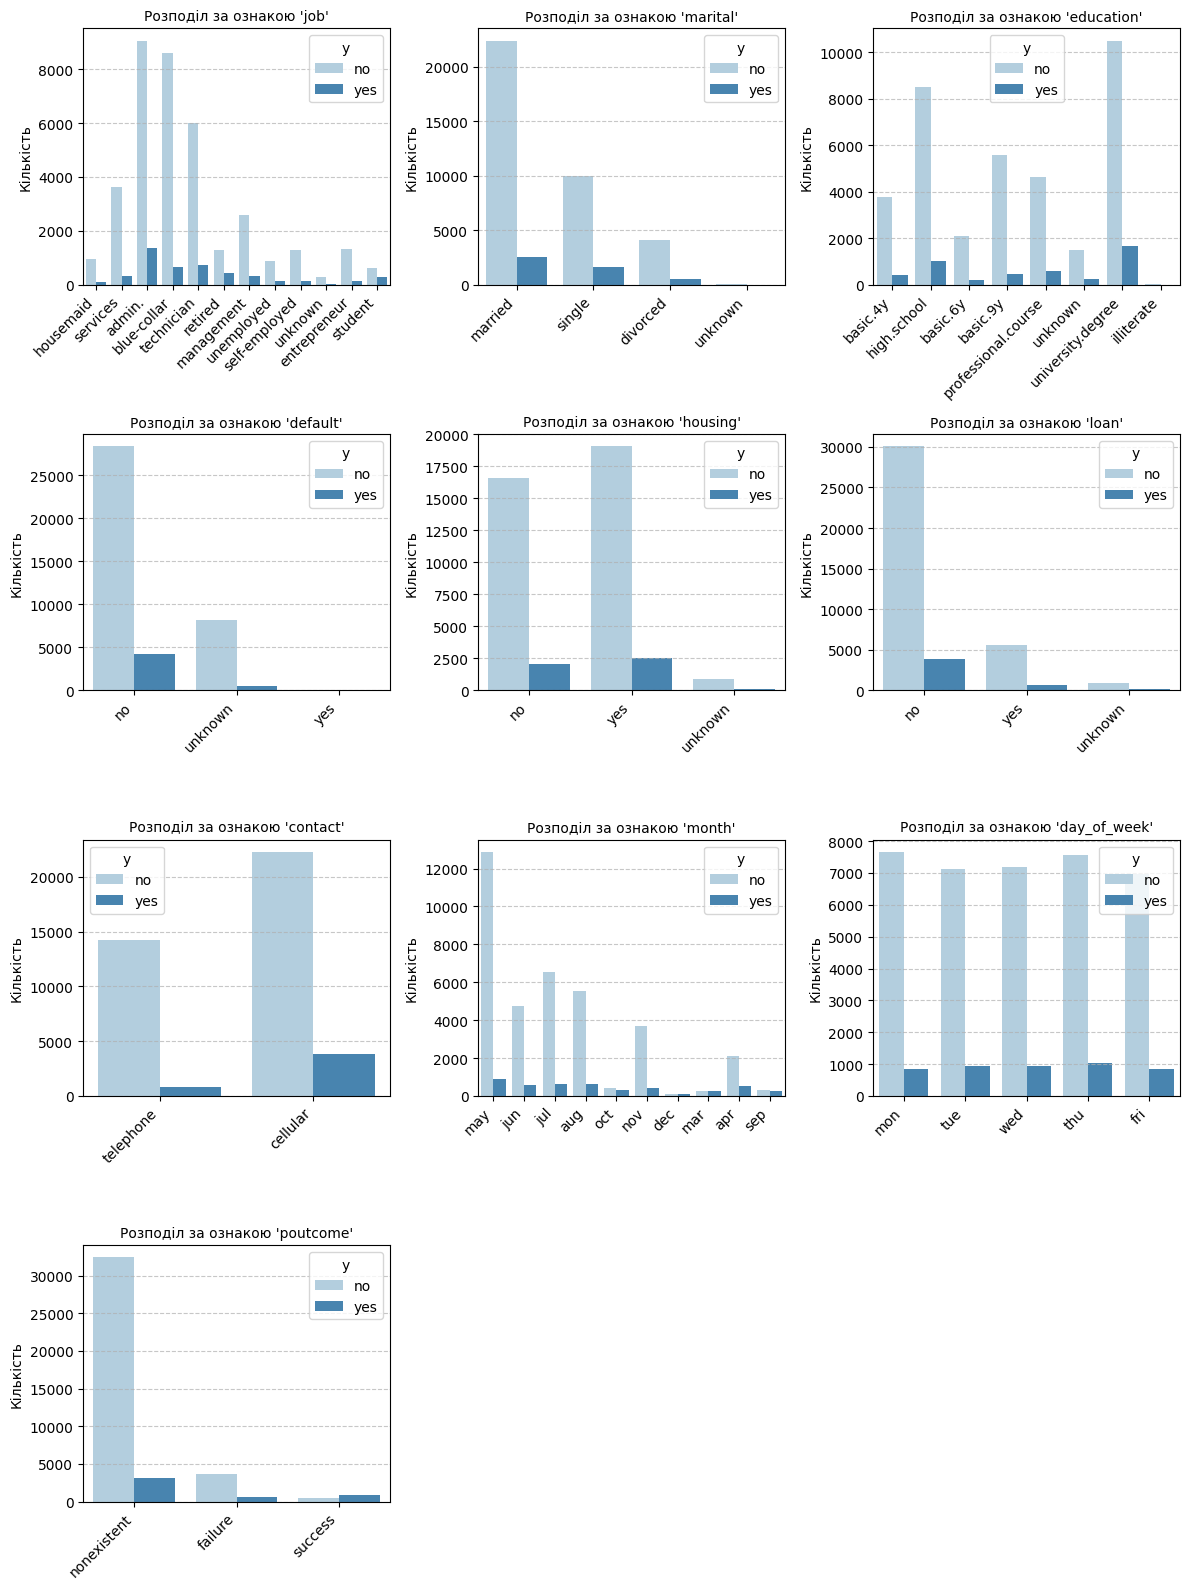

In [16]:
# Виключаємо цільову змінну зі списку категоріальних колонок
categorical_cols = [col for col in categorical_cols if col != 'y']

# Побудова графіків
plt.figure(figsize=(12, 16))

for i, col in enumerate(categorical_cols, 1):
    ax = plt.subplot(4, 3, i)
    sns.countplot(data=df, x=col, hue='y', palette='Blues', ax=ax)
    ax.set_title(f"Розподіл за ознакою '{col}'", fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel("")
    ax.set_ylabel("Кількість")
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


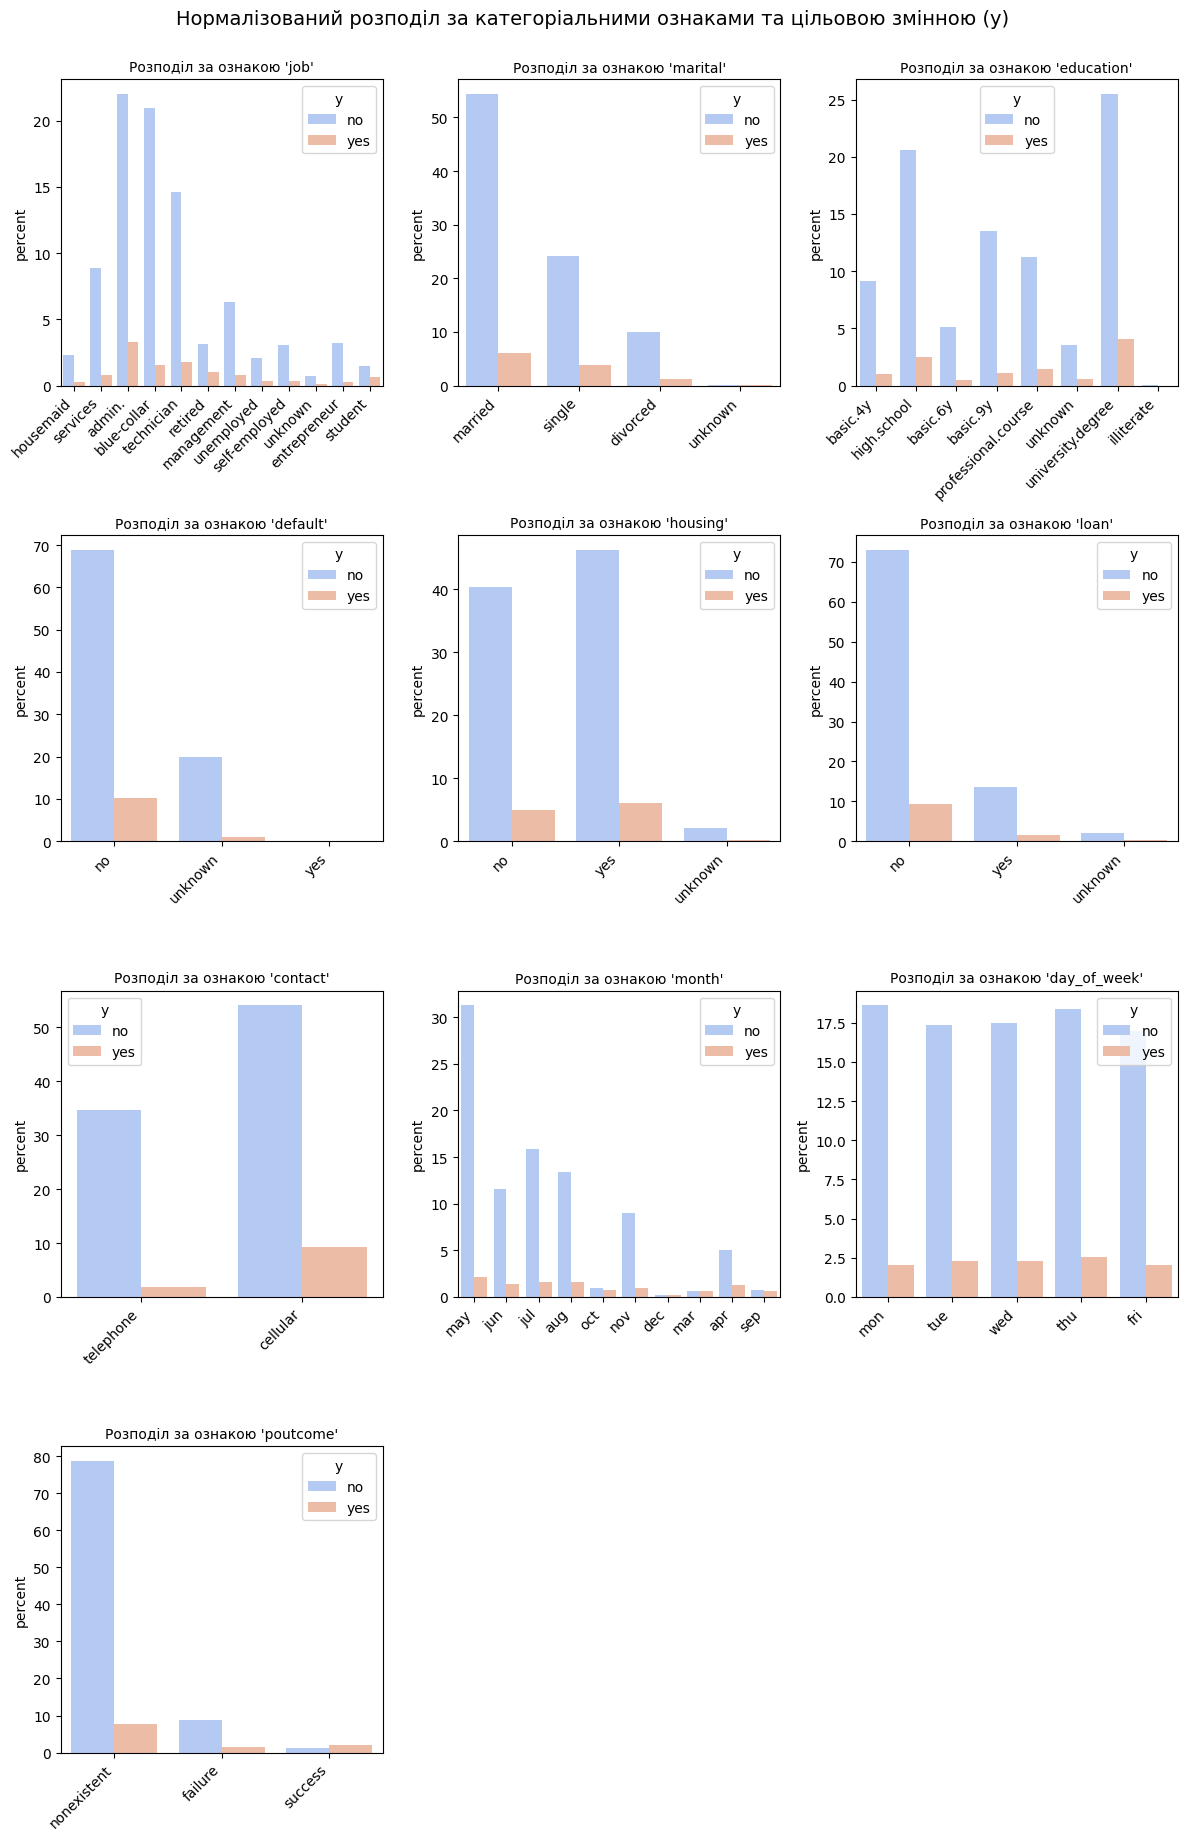

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Перевіряємо, чи є цільова змінна у списку категоріальних колонок, і виключаємо її
categorical_cols = [col for col in categorical_cols if col != 'y']

# Побудова графіків
plt.figure(figsize=(12, 18))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 3, i)
    sns.countplot(data=df, x=col, hue='y', palette='coolwarm', stat="percent")
    plt.title(f"Pозподіл за ознакою '{col}'", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("")


plt.tight_layout()
plt.suptitle("Нормалізований розподіл за категоріальними ознаками та цільовою змінною (y)", fontsize=14, y=1.02)
plt.show()

Висновки на основі розподілів категоріальних ознак у розрізі цільової змінної y:

**job**

Найбільше клієнтів — із категорій blue-collar, admin., technician. Найвищий відсоток клієнтів, що оформили депозит спостерігається серед students, retired і unemployed — хоча їх чисельність невелика. Найменше підписаних контрактів у unemployed та services.

**marital**
Основна частина клієнтів — одружені, проте частка згод на депозит у них нижча, ніж у single або divorced. Single демонструють вищу готовність до підписання депозиту.

**education**
Найбільше клієнтів, що підписали депозит мають university.degree та high.school і більший відсоток підписаних депозитів серед цих категорій. У змінній default значення unknown становить значну частину — понад 20%, це означає, що для кожного п’ятого клієнта банк не мав або не зафіксував інформацію щодо простроченого кредиту.

**default**
Переважна більшість клієнтів не мають прострочених кредитів. Ймовірність підписання депозиту вища у клієнтів без боргів.

**housing**
Клієнти без іпотеки частіше погоджуються, ніж ті, хто має іпотечний кредит.

**loan**
Більшість клієнтів не мають споживчих кредитів. Схожа тенденція як для змінної housing: клієнти без кредиту частіше погоджуються на підписання депозиту, ніж ті, хто мають споживчий кредит.

**contact**
Частіше використовувався cellular зв'язок. Значно вищий процент підписання депозиту у клієнтів, з якими контактували через cellular порівняно з telephone.

**month**
Найбільше дзвінків здійснено в травні, липні та серпні, з піком саме в травні. Це свідчить про найактивнішу фазу маркетингової кампанії у ці місяці.
Найвищий відсоток клієнтів, що оформили депозит - у березні, грудні та жовтні, хоча кількість котактів у ці місяці мала.

**day_of_week**
Розподіл рівномірний по днях тижня. День не має суттєвого впливу на результат кампанії.

**poutcome**
Більшість клієнтів не брали участь у попередній кампанії (nonexistent).Найвища частка підписаних депозитів серед клієнтів із попереднім успішним досвідом — success, що свідчить про значну роль попереднього контакту. Якщо попередня кампанія була невдалою (failure), позитивних відповідей мало. Якщо результат невідомий (nonexistent) — також багато "no".



Загальні висновки

**Фактори, що асоціюються з вищою ймовірністю позитивної відповіді ("yes"):**

Соціально-демографічні характеристики: Найбільшу ймовірність згоди демонструють пенсіонери, студенти та клієнти з вищою освітою.

Фінансова стабільність: Клієнти, які не мають активних боргів або споживчих кредитів, частіше дають позитивну відповідь.

Канал комунікації: Контакти, здійснені через мобільний телефон, мають значно вищу ефективність.

Минулі взаємодії: Особи, які вже брали участь у попередніх кампаніях і виявили інтерес, мають підвищену конверсію.

**Фактори, що знижують ймовірність позитивної відповіді:**

Фінансове навантаження: Наявність заборгованостей або поточних кредитів негативно впливає на схильність до згоди на підписання депозиту.

Низький рівень освіти: Особи з базовою або середньою освітою демонструють нижчу зацікавленість.

Канал зв’язку: Використання стаціонарного телефону корелює з нижчими показниками залучення.

Сезонний чинник: Кампанії, проведені в осінньо-зимовий період, демонструють нижчу ефективність.



Висновки щодо подальшої обробки категоріальних змінних:

1. Обробка пропущених/невідомих значень:

unknown часто трапляється в default, education, housing, loan — ці значення потребують явної обробки (маркування окремою категорією або заповнення).

2. Дисбаланс цільової змінної y:

Вимагає спеціального підходу до навчання моделі, щоб уникнути переваги більшості.

3. Корисні змінні для прогнозування:
job, education, month, poutcome — мають достатню варіативність і потенційно впливають на y.

4. Змінні-кандидати на видалення або трансформацію:
default — дуже сильний дисбаланс, фактично майже бінарна змінна з переважанням "no".

day_of_week — рівномірний розподіл, потенційно слабка предиктивна сила.

In [18]:
# Відсотковий розподіл
df['y'].value_counts(normalize=True) * 100

,proportion
y,
no,88.733728
yes,11.266272


Аналіз цільової змінної (y):

Класовий дисбаланс:

88.73% клієнтів не підписали депозит.

Лише 11.27% підписали депозит.

Це означає, що модель може навчитися просто передбачати "ні" і отримувати високу точність, але це не буде корисним.

Для коректної оцінки моделі використаємо AUC-ROC, F1-score, а також можемо застосувати балансування класів (наприклад, oversampling/undersampling, SMOTE).

# Аналіз числових змінних

### Зведена статистика для числових змінних

In [19]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Основні спостереження:

age (вік): Вік клієнтів варіюється від 17 до 98 років, середнє значення становить близько 40 років. Стандартне відхилення (~10.4) свідчить про різноманітність вікових груп серед клієнтів.

duration (тривалість дзвінка): Значення коливаються від 0 до 4918 секунд, середня тривалість — 258 секунд. Ця змінна має сильний вплив на цільову змінну і її значення стає відомим лише після дзвінка, тобто після завершення взаємодії з клієнтом. duration будемо використовувати лише для дослідницького аналізу.

campaign (кількість контактів під час поточної кампанії): У більшості випадків з клієнтом контактували 1–3 рази, проте є спостереження з аномально високими значеннями (до 56 контактів), які можуть бути винятковими або помилковими.

pdays (кількість днів з моменту останнього контакту): значення 999 кодове і вказує на те, що з клієнтом раніше не контактували.

previous (кількість попередніх контактів): У більшості клієнтів кількість попередніх контактів дорівнює 0, що свідчить про відсутність історії взаємодії в межах попередніх кампаній.

Макроекономічні показники (emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed): Ці змінні мають різний діапазон значень, що відображає зміну економічних умов у часі. Наприклад, euribor3m має середнє значення близько 3.62, з мінімумом 0.634 і максимумом 5.045, що може вказувати на зміну економічного циклу. Такі змінні можуть бути важливими факторами для моделювання поведінки клієнтів.



Поглянемо ще додатково на розподіл наших числових змінних візуально, побудуємо для цього гістограми.

<Figure size 1200x1000 with 0 Axes>

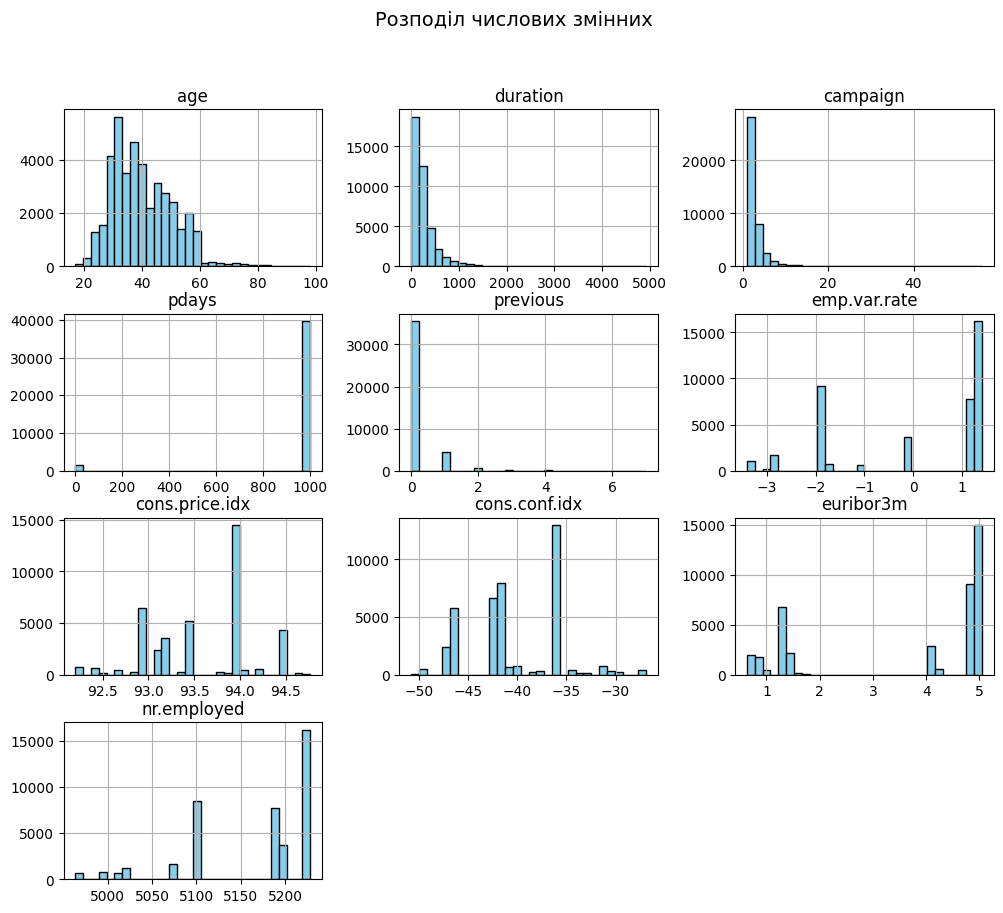

In [21]:
# Гістограми числових змінних
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12, 10))
df[numeric_cols].hist(bins=30, figsize=(12, 10), color='skyblue', edgecolor='black', layout=(4, 3))
plt.suptitle("Розподіл числових змінних", fontsize=14)
plt.show();

Ми можемо додати до наших спостережень ще наступну інформацію:
**age**
Бачимо , що розподіл віку має асиметричну форму з хвостом праворуч.
Найбільше клієнтів — у віці приблизно 30–40 років, але є значна кількість і старших (до 90 років).

**duration**
Більшість дзвінків тривають до 500 секунд, але є й поодинокі значення до 5000 секунд. Як вказувалось раніше, цю змінну ми не будемо використовувати для передбачення, бо вона пост-фактум.

**pdays**
Є два чіткі піки:

Один на 999 — це кодове значення для "не було контакту раніше". Інший — на дуже малих значеннях (нещодавній контакт).


**previous**
Більшість клієнтів не мали жодного попереднього контакту (значення 0).Інші значення трапляються значно рідше.

**emp.var.rate** (зміна рівня зайнятості)
Розподіл дискретний, із декількома сталими значеннями.

Найбільше спостережень при позитивному значенні темпу зміни (1.1).

**cons.price.idx** та **cons.conf.idx**
Обидві змінні мають невелике число унікальних значень — скоріш за все це макроекономічні індикатори на момент контакту.

cons.price.idx — має пік біля 94.7.

cons.conf.idx — більшість значень між -50 і -30 (негативна споживча впевненість).

**euribor3m**
Має великий пік на рівні ~5.0, це вказує на період високої базової ставки.

Є також значення ближчі до 1.0–2.0, тобто більш "дешеві гроші".

**nr.employed**
Змінна має декілька сталих значень, пік — близько 5200, це теж макроекономічний показник.



In [22]:
# Кількість унікальних значень для числових колонок
print(df[numeric_cols].nunique())

age                 78
duration          1544
campaign            42
pdays               27
previous             8
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
dtype: int64


In [23]:
for col in numeric_cols:
    print(f"Розподіл значень у колонці '{col}':")
    print(df[col].value_counts())
    print("\n" + "-"*20 + "\n")

Розподіл значень у колонці 'age':
age
31    1947
32    1845
33    1833
36    1779
35    1758
      ... 
91       2
98       2
95       1
87       1
94       1
Name: count, Length: 78, dtype: int64

--------------------

Розподіл значень у колонці 'duration':
duration
85      170
90      170
136     168
73      167
124     163
       ... 
1356      1
1103      1
1992      1
3183      1
1399      1
Name: count, Length: 1544, dtype: int64

--------------------

Розподіл значень у колонці 'campaign':
campaign
1     17634
2     10568
3      5340
4      2650
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
30        7
31        7
35        5
33        4
32        4
34        3
43        2
40        2
42        2
39        1
56        1
37       

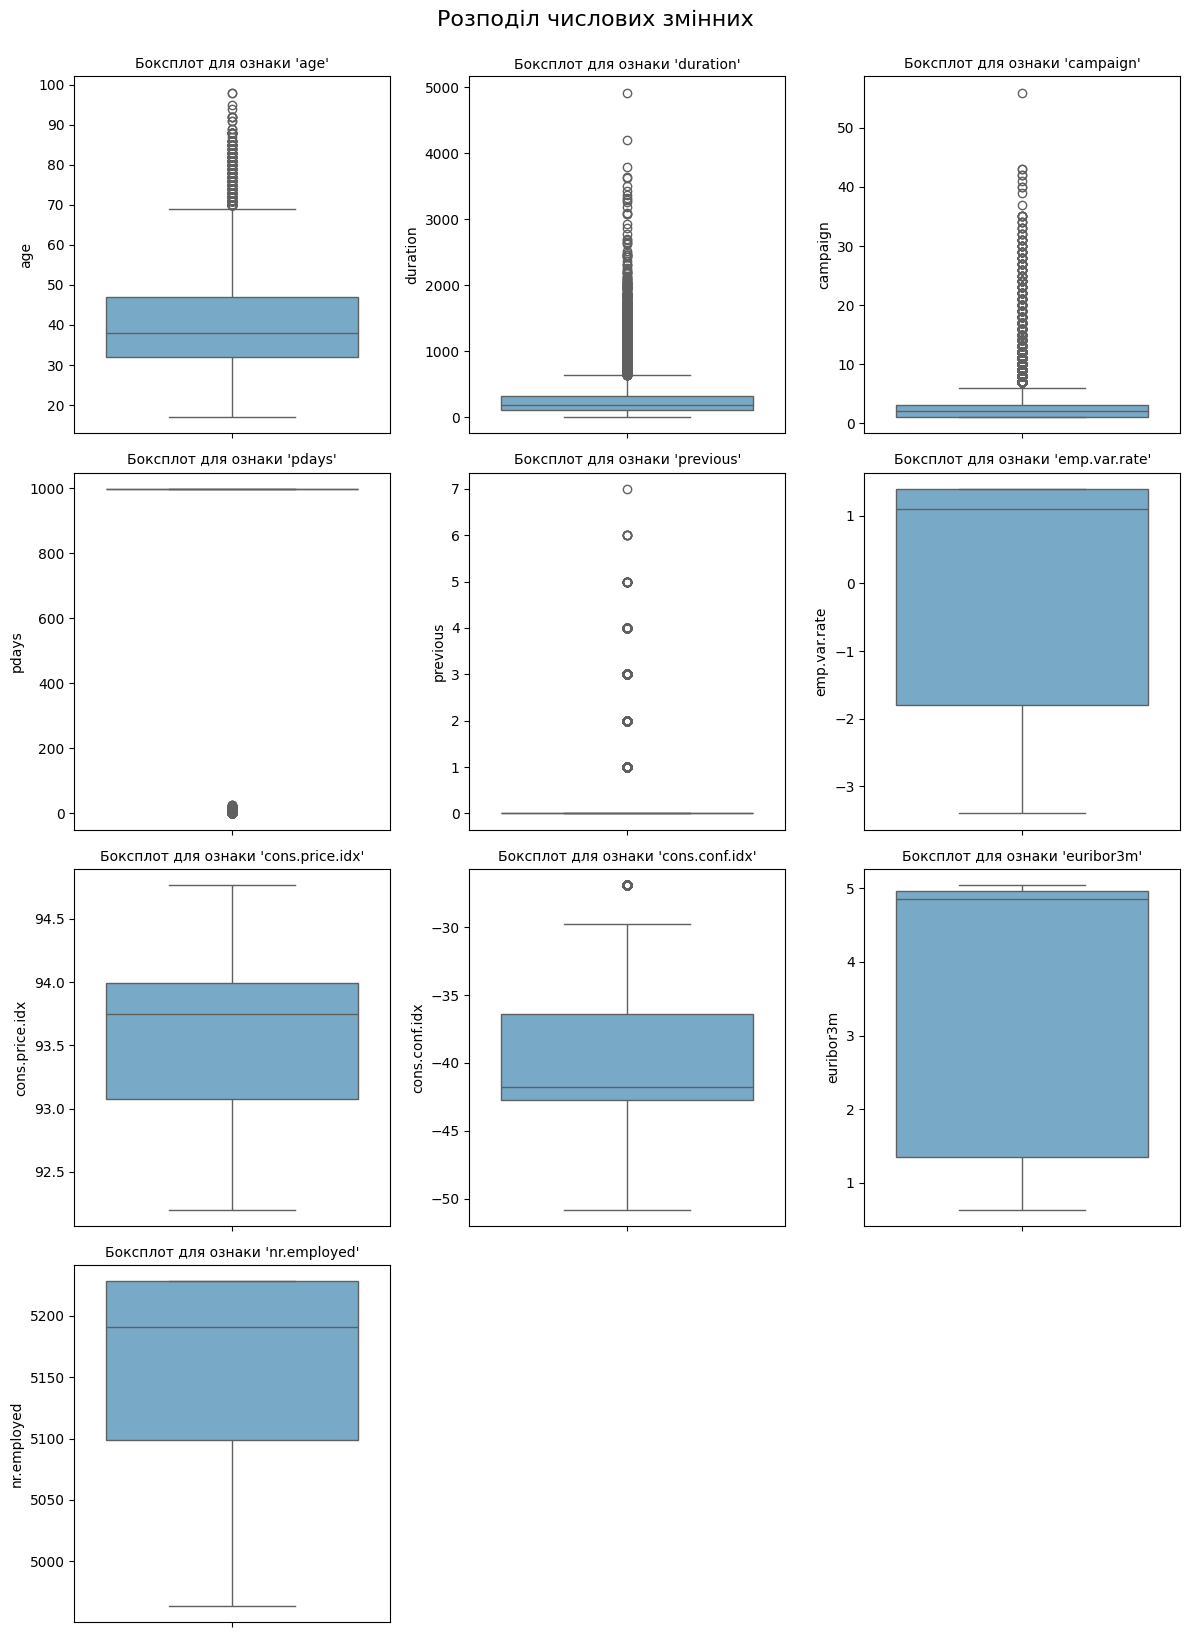

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Побудова графіків для числових змінних
plt.figure(figsize=(12, 16))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)  # Створюємо підграфік на 4 рядках і 3 стовпцях
    sns.boxplot(data=df, y=col, palette='Blues')
    plt.title(f"Боксплот для ознаки '{col}'", fontsize=10)
    plt.ylabel(f"{col}")

plt.tight_layout()  # Автоматичне вирівнювання графіків
plt.suptitle("Розподіл числових змінних", fontsize=16, y=1.02)
plt.show()


Поглянемо на викиди у наших даних.

In [26]:
import pandas as pd
import numpy as np
from typing import Tuple

def outlier_bounds(df: pd.DataFrame, column: str) -> Tuple[float, float]:
    """
    Calculate IQR-based bounds for outlier detection.

    Args:
        df (pd.DataFrame): Input DataFrame
        column (str): Column name to analyze

    Returns:
        Tuple[float, float]: Lower and upper bounds for outliers
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound


In [27]:
def find_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find columns with outliers using IQR method and return a DataFrame
    showing both count and percentage of outliers in each numeric column.

    Args:
        df (pd.DataFrame): Input DataFrame

    Returns:
        pd.DataFrame: DataFrame with count and percentage of outliers
    """
    outlier_stats = {}

    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        lower, upper = outlier_bounds(df, col)
        outliers = (df[col] < lower) | (df[col] > upper)
        count = outliers.sum()
        percent = round(100 * count / len(df), 2)
        outlier_stats[col] = {'Outlier Count': count, 'Outlier %': percent}

    return pd.DataFrame.from_dict(outlier_stats, orient='index')


In [28]:
outlier_summary = find_outliers(df)
print(outlier_summary)

                Outlier Count  Outlier %
age                       468       1.14
duration                 2963       7.20
campaign                 2406       5.84
pdays                    1515       3.68
previous                 5625      13.66
emp.var.rate                0       0.00
cons.price.idx              0       0.00
cons.conf.idx             446       1.08
euribor3m                   0       0.00
nr.employed                 0       0.00


Спостеженення:
**campaign** (5.84% - аутлаєри)
Основна маса клієнтів мала 1–3 дзвінки, викидами є значення 10+ (аж до 56).

Такі викиди можуть бути індикатором надмірної кількості контактів, що потенційно знижує шанси на позитивну відповідь, або вказує на неефективність комунікації.

**previous** (13.66% аутлаєри)

З аналізу розподілу видно, що більшість клієнтів мали 0 або 1 попередній контакт, а значення понад 3 вже є рідкісними. Значення 4–7 утворюють «довгий хвіст». Це може вказувати на окрему групу клієнтів, які або є постійними клієнтами, або потребували багатьох спроб зв'язку.

**duration** (7.19% )
Змінна, що показує тривалість останнього дзвінка. Має сильно скошений розподіл: більшість значень до 500 секунд, але є поодинокі дзвінки до 5000 секунд. Викиди тут логічні — довші розмови трапляються рідко, але потенційно інформативні (зокрема для відповіді "yes").

**age** (1.14%)
Викиди переважно стосуються клієнтів старше 70 років, що видно також з розподілу.

**cons.conf.idx** (1.09%)
Викиди — періоди з нетиповими значеннями індексу (наприклад, -26.9 або -50.8), що відображають екстремальні економічні настрої. Вони можуть відповідати кризовим або передвиборчим періодам.


Поглянемо більш детально на розподіл числових змінних у нашому датасеті за допомогою методу describe() з параметром percentiles, щоб краще зрозуміти статистику і прийняти обгрунтовані рішення щодо викидів.

In [29]:
df.describe(percentiles = [0.75, 0.99, 0.9999])

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
99%,71.00000,1271.250000,14.000000,999.000000,2.000000,1.400000,94.465000,-26.900000,4.968000,5228.100000
99.99%,92.00000,3616.665000,41.882500,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Порахуємо, яка частка клієнтів має значення 999 у колонці pdays

In [30]:
import numpy as np

pdays_999_share = np.mean(df['pdays'] == 999)
print(f"Частка клієнтів, з якими не контактували раніше: {pdays_999_share:.2%}")

Частка клієнтів, з якими не контактували раніше: 96.32%


Як показує результат, з 96.32% клієнтів не контактували раніше. Для нашого завдання буде корисно створити нову змінну contacted_before. Це перетворення зробить змінну зручнішою для моделювання.

In [31]:
df['contacted_before'] = (df['pdays'] != 999).astype(int)

Проаналізуємо також окремо змінну campaign

In [32]:
# Обчислюємо 99-й перцентиль для змінної 'campaign'
q99 = df['campaign'].quantile(0.99)
q99

np.float64(14.0)

Як ми бачимо, кількість контактів на 99-му перцентилі становить 14. Використаємо метод clip(), щоб обмежити значення змінної 'campaign', встановивши верхню межу на 14. Це зробить дані більш підходящими для моделювання.

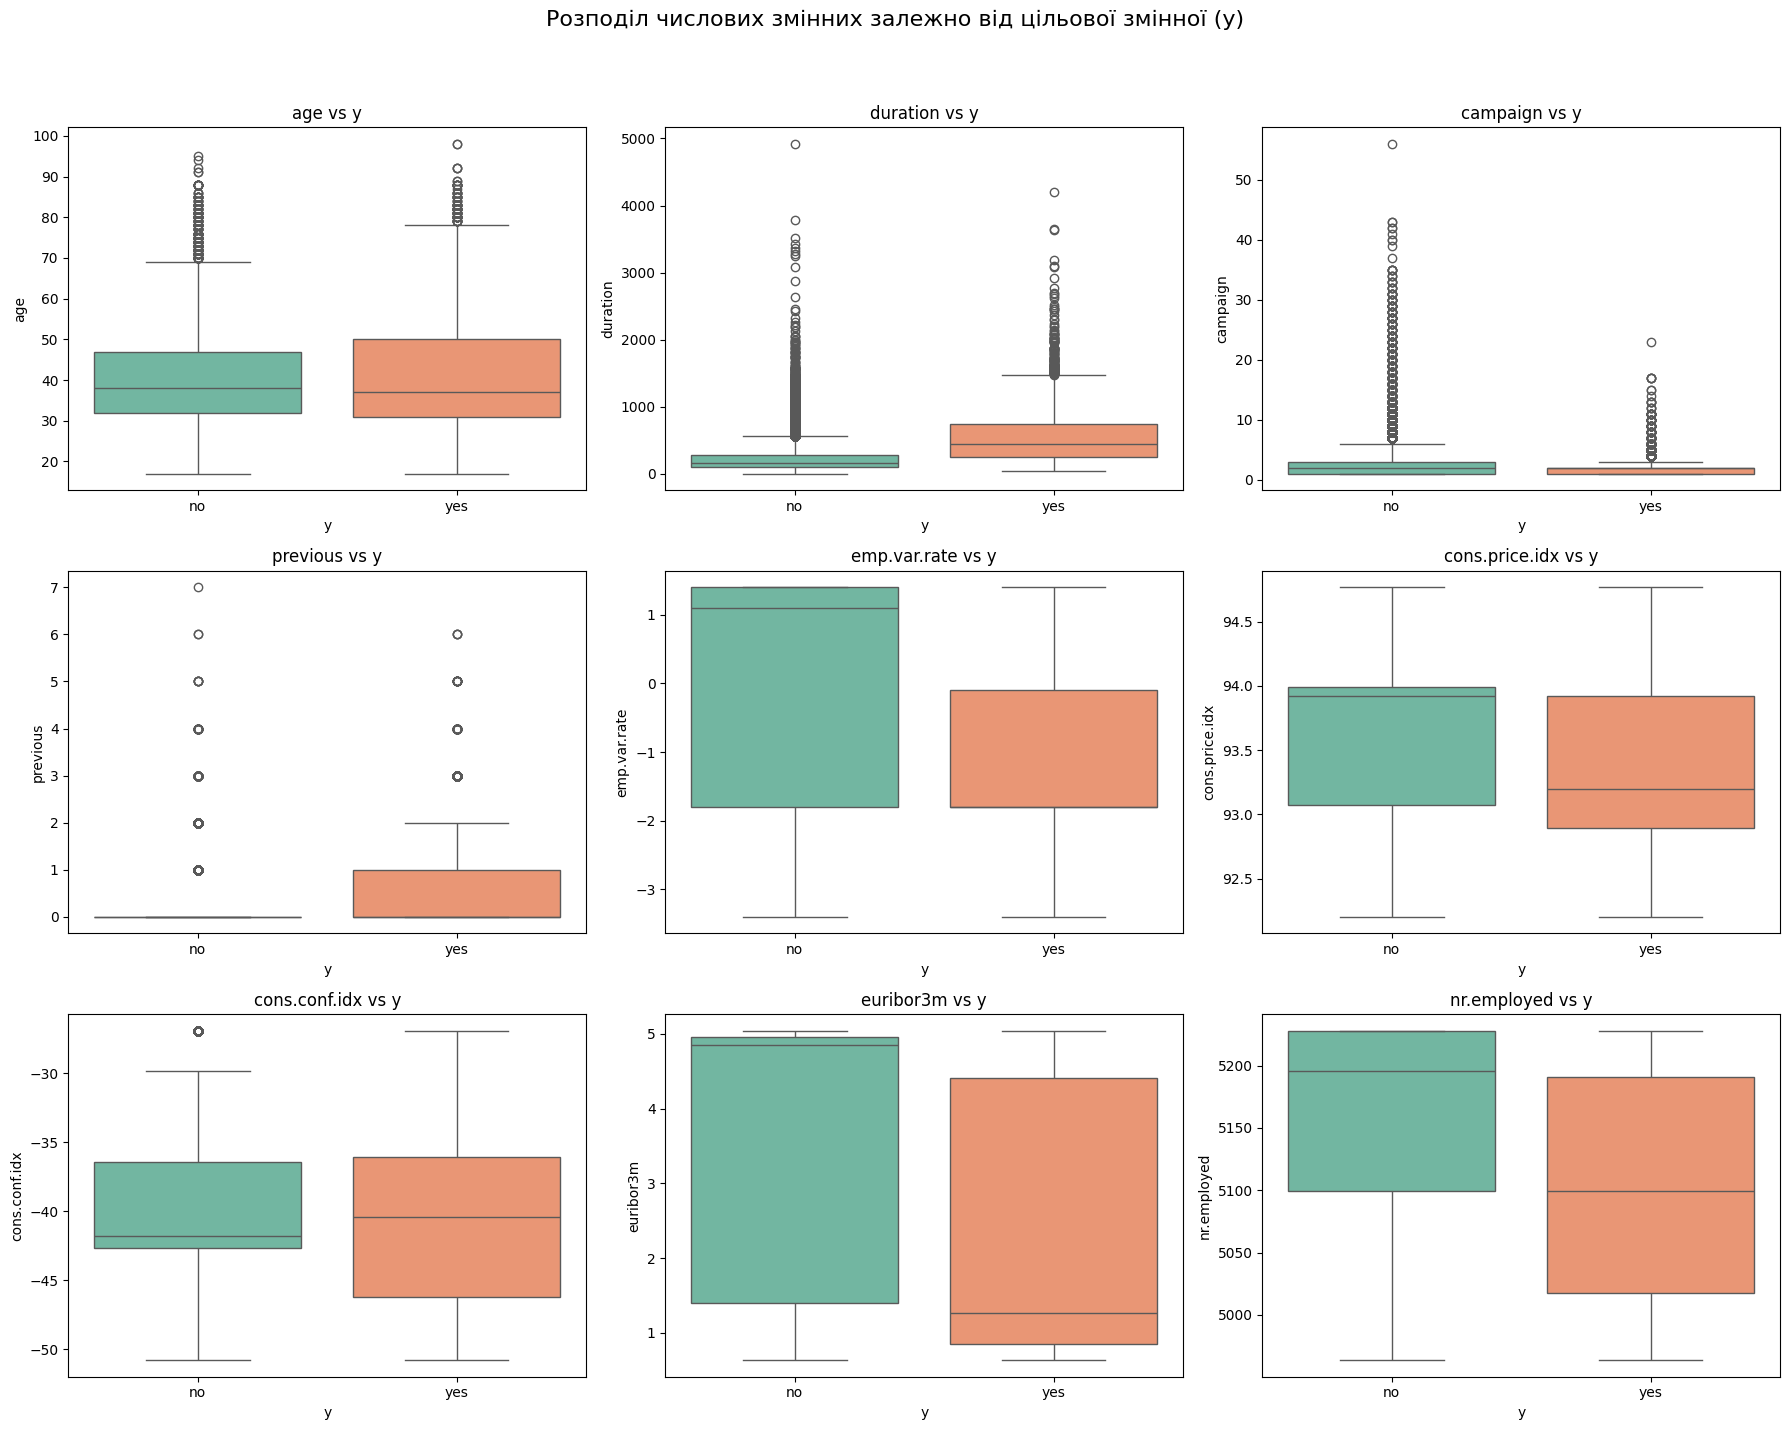

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Список числових змінних (крім цільової змінної)
numerical_cols = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Створення графіків
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Заголовок для всіх графіків
fig.suptitle('Розподіл числових змінних залежно від цільової змінної (y)', fontsize=16)

# Цикл для побудови боксплотів для кожної числової змінної
for i, col in enumerate(numerical_cols):
    row, col_idx = divmod(i, 3)  # Визначаємо позицію графіка в сітці
    sns.boxplot(x='y', y=col, data=df, ax=axes[row, col_idx], palette='Set2')
    axes[row, col_idx].set_title(f'{col} vs y', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Спостереження по деяким числовим змінним:

1. Вік (age vs y):
Медіана віку клієнтів, які підписали депозит, трохи вища, ніж у тих, хто відповів "no". Проте розподіл досить схожий: підписують як молоді, так і старші люди.

Висновок: вік має певний вплив, але він незначний.

2. Тривалість дзвінка (duration vs y)
Явна відмінність: чим довше триває дзвінок, тим вища ймовірність позитивної відповіді.

Висновок: сильний предиктор, але лише для аналізу, не для передбачення.

3. Кількість контактів у поточній кампанії (campaign vs y)
Для обох груп розподіл схожий, але:

Клієнти, які відмовилися, мали більшу кількість контактів.

Висновок: часті контакти не завжди ефективні — повторний контакт може знижувати успіх.

4. Кількість контактів у попередніх кампаніях (previous vs y):
У клієнтів з позитивною відповіддю значення вищі, медіана більша.

Висновок: попередній досвід контакту з банком може позитивно впливати на ймовірність підписання депозиту.

5. Темп зміни зайнятості (emp.var.rate vs y). Ті клієнти, хто погодився підписати депозит, мали значно нижчі значення зосереджені в області негативного темпу (переважно -1.8 або -3.4).

Висновок: у періоди спаду економіки або нестабільності на ринку праці (від’ємне значення emp.var.rate), клієнти більш схильні до відкриття депозиту — імовірно, через потребу у фінансовій стабільності.

6. Індекс споживчих цін (cons.price.idx vs y):
В обох групах (yes та no) розподіл близький, але:

"Yes" відповіді дещо зміщені до нижчих значень (93.2–93.5).

"No" відповіді мають ширший діапазон (93.2–94.8).

Висновок: клієнти, які погоджуються на депозит, частіше це роблять в періоди стабільних цін, коли інфляція сповільнюється.

7. Індекс довіри споживачів (cons.conf.idx vs y)
Ті, хто підписав депозит, мали більш негативну оцінку економічної ситуації.

8. Euribor на 3 місяці (euribor3m vs y). Найбільша відмінність між групами:

Ті, хто погодився (yes), мають значення Euribor значно нижчі (навіть < 1.5).

Висновок: у періоди низьких відсоткових ставок, банки можуть активніше пропонувати депозити, і клієнти частіше на них погоджуються — можливо, через відсутність альтернатив для збереження коштів з дохідністю.

9. Значення nr.employed нижчі серед тих, хто погодився підписати депозит.

Висновок: економічна нестабільність (нижчий рівень зайнятості) збільшує схильність до заощаджень.



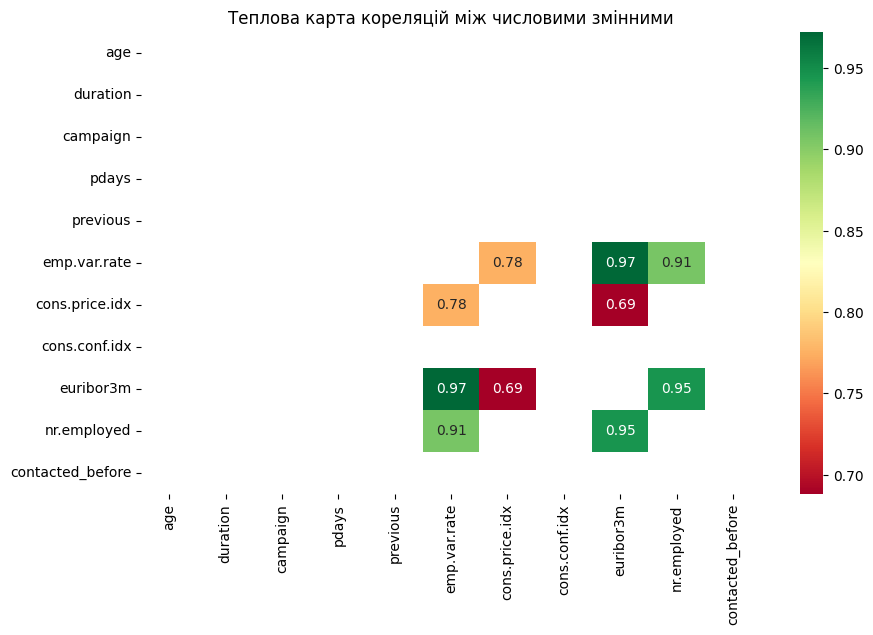

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Теплова карта кореляцій для числових змінних
plt.figure(figsize=(10, 6))

# Вибираємо лише числові змінні з датафрейму
numeric_df = df.select_dtypes(include=[np.number])

# Обчислюємо матрицю кореляцій
correlation = numeric_df.corr()

# Побудова теплової карти
#sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
sns.heatmap(data = correlation[(correlation >= 0.6) & (correlation < 0.9999)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')


# Заголовок графіка
plt.title("Теплова карта кореляцій між числовими змінними")
plt.show()


Ключові кореляції між змінними:
- euribor3m має дуже сильний позитивний зв’язок із emp.var.rate (0.97),
nr.employed (0.95).

- emp.var.rate також сильно корелює з nr.employed (0.91)

- cons.price.idx корелює з emp.var.rate (0.78) і previous (0.78)

- cons.conf.idx має негативну кореляцію з euribor3m (-0.69)

Змінні emp.var.rate, euribor3m, nr.employed — схожі між собою за інформацією, тому при моделюванні будемо це враховувати: може знадобитися виключення однієї з них.

In [35]:
# Перетворюємо цільову змінну 'y' на числову (1 для 'yes', 0 для 'no')
df['y'] = df['y'].map({'yes': 1, 'no': 0})

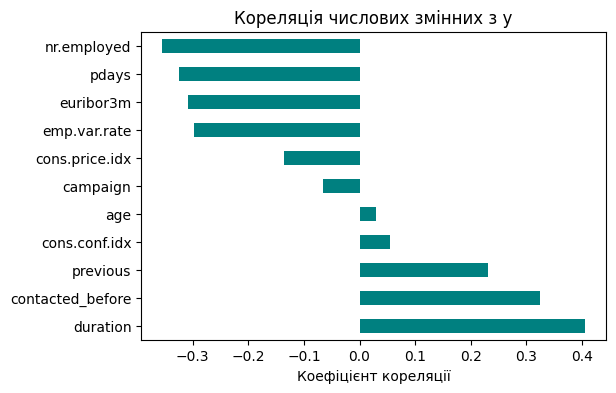

In [36]:
numeric_df_y = df.select_dtypes(include='number')
correlation = numeric_df_y.corr()
correlation['y'].drop('y').sort_values(ascending=False).plot(kind='barh', figsize=(6,4), color='teal')
plt.title('Кореляція числових змінних з y')
plt.xlabel('Коефіцієнт кореляції')
plt.show()

In [37]:
print(correlation['y'].sort_values(ascending=False))

y                   1.000000
duration            0.405297
contacted_before    0.324910
previous            0.230202
cons.conf.idx       0.054802
age                 0.030381
campaign           -0.066361
cons.price.idx     -0.136134
emp.var.rate       -0.298289
euribor3m          -0.307740
pdays              -0.324948
nr.employed        -0.354669
Name: y, dtype: float64


Спостереження:
duration 0.40 — має найвищу позитивну кореляцію з цільовою змінною, тобто чим довше триває дзвінок, тим вища ймовірність згоди клієнта. Найсильніший предиктор, але його не використовуємо при побудові моделі.

previous 0.35 - клієнти, з якими контактували раніше, частіше погоджуються.

nr.employed -0.35- найсильніша негативна кореляція: більше працевлаштованих — менше підписок. Це може бути пов’язано з економічним підйомом, коли клієнти менше потребують депозитів.

pdays, emp.var.rate, euribor3m — також цінні ознаки.

Інші мають менший вплив, але можуть давати користь у сукупності.